In [ ]:

import ast
from itertools import chain

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from sklearn.model_selection import train_test_split
from torch import optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from tqdm.notebook import tqdm
from transformers import AutoModel, AutoTokenizer, AutoModelForMaskedLM

In [ ]:
#display options
pd.set_option('display.max_colwidth', None)

In [ ]:
basepath='./NBMEData/'
patient_notes_path = basepath + 'patient_notes.csv'
train_path = basepath+'train.csv'
features_path = basepath+'features.csv'

In [ ]:
patient_notes = pd.read_csv(patient_notes_path)
features = pd.read_csv(features_path)
train = pd.read_csv(train_path)


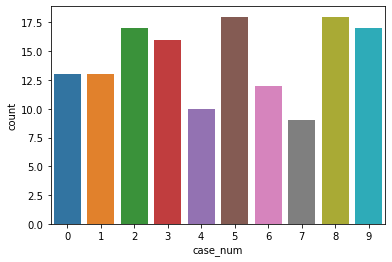

In [ ]:
sns.countplot(data=features, x='case_num')
plt.show()

# Helper Functions and classes
### 1. Create merged data set
need to merge `features.csv`, `patient_notes.csv` with `train.csv`

In [ ]:
BASE_URL = "./NBMEData"


def process_feature_text(text):
    return text.replace("-OR-", ";-").replace("-", " ")


def prepare_datasets():
    ## load data
    features = pd.read_csv(f"{BASE_URL}/features.csv")
    notes = pd.read_csv(f"{BASE_URL}/patient_notes.csv")
    df = pd.read_csv(f"{BASE_URL}/train.csv")
    ## convert strings into python lists
    df["annotation_list"] = [ast.literal_eval(x) for x in df["annotation"]]
    df["location_list"] = [ast.literal_eval(x) for x in df["location"]]
    ##merge data sets
    merged = df.merge(notes, how="left")
    merged = merged.merge(features, how="left")

    merged["feature_text"] = [process_feature_text(x) for x in
                              merged["feature_text"]]
    merged["feature_text"] = merged["feature_text"].apply(lambda x: x.lower())
    merged["pn_history"] = merged["pn_history"].apply(lambda x: x.lower())

    return merged




### 2. Create tokenizers

In [ ]:
def loc_list_to_ints(loc_list):
    to_return = []
    for loc_str in loc_list:
        loc_strs = loc_str.split(";")
        for loc in loc_strs:
            start, end = loc.split()
            to_return.append((int(start), int(end)))
    return to_return


def tokenize_and_add_labels(tokenizer, data, config):
    out = tokenizer(
        data["feature_text"],
        data["pn_history"],
        truncation=config['truncation'],
        max_length=config['max_length'],
        padding=config['padding'],
        return_offsets_mapping=config['return_offsets_mapping']
    )
    labels = [0.0] * len(out["input_ids"])
    out["location_int"] = loc_list_to_ints(data["location_list"])
    out["sequence_ids"] = out.sequence_ids()

    for idx, (seq_id, offsets) in enumerate(zip(out["sequence_ids"],
                                                out["offset_mapping"])):
        if not seq_id or seq_id == 0:
            labels[idx] = -1
            continue

        token_start, token_end = offsets
        for feature_start, feature_end in out["location_int"]:
            if token_start >= feature_start and token_end <= feature_end:
                labels[idx] = 1.0
                break

    out["labels"] = labels

    return out



# 3. create a Dataset that can use data, tokenizer, and config
Dataset class will incorporate attention mask, tokens, and the model hyperparameters as a config file

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, data, tokenizer, config):
        self.data = data
        self.tokenizer = tokenizer
        self.config = config  ## hyperparameter values for neural network

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        data = self.data.iloc[idx]
        tokens = tokenize_and_add_labels(self.tokenizer, data, self.config)

        input_ids = np.array(tokens["input_ids"])
        attention_mask = np.array(tokens["attention_mask"])
        token_type_ids = np.array(tokens["token_type_ids"])

        labels = np.array(tokens["labels"])
        offset_mapping = np.array(tokens['offset_mapping'])
        sequence_ids = np.array(tokens['sequence_ids']).astype("float16")
        
        return input_ids, attention_mask, token_type_ids, labels, offset_mapping, sequence_ids

# 4. create Neural network Model as a class
- initial set up used  **Pub med BERT** base Architecture downloaded at https://www.kaggle.com/jpmiller/layoutlm with  2 FC layers
- can change to use hugging face models


In [ ]:
import torch.nn.functional as F


class CustomModel(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.bert = AutoModel.from_pretrained(config['model_name']) 
        # self.bert = AutoModelForMaskedLM.from_pretrained(config['model_name']) 
        self.dropout = nn.Dropout(p=config['dropout'])
        self.config = config
        self.fc1 = nn.Linear(768, 512)
        # self.fc1a = nn.Linear(512, 256)  ##added additional fully connected layer
        self.fc2 = nn.Linear(512, 1)
        

    def forward(self, input_ids, attention_mask, token_type_ids):
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask,
                            token_type_ids=token_type_ids)
        logits = F.relu(self.fc1(outputs[0]))
        # logits = F.relu(self.fc1a(logits)) ##added additional fully connected layer
        logits = self.fc2(self.dropout(logits)).squeeze(-1)
        return logits
    
    


### 5. functions to measure performance of model and get predictions

In [ ]:
def get_location_predictions(preds, offset_mapping, sequence_ids, test=False):
    all_predictions = []
    for pred, offsets, seq_ids in zip(preds, offset_mapping, sequence_ids):
        pred = 1 / (1 + np.exp(-pred))
        start_idx = None
        end_idx = None
        current_preds = []
        for pred, offset, seq_id in zip(pred, offsets, seq_ids):
            if seq_id is None or seq_id == 0:
                continue

            if pred > 0.5:
                if start_idx is None:
                    start_idx = offset[0]
                end_idx = offset[1]
            elif start_idx is not None:
                if test:
                    current_preds.append(f"{start_idx} {end_idx}")
                else:
                    current_preds.append((start_idx, end_idx))
                start_idx = None
        if test:
            all_predictions.append("; ".join(current_preds))
        else:
            all_predictions.append(current_preds)
            
    return all_predictions



def calculate_char_cv(predictions, offset_mapping, sequence_ids, labels):
    all_labels = []
    all_preds = []
    for preds, offsets, seq_ids, labels in zip(predictions, offset_mapping,
                                               sequence_ids, labels):

        num_chars = max(list(chain(*offsets)))
        char_labels = np.zeros(num_chars)

        for o, s_id, label in zip(offsets, seq_ids, labels):
            if s_id is None or s_id == 0:
                continue
            if int(label) == 1:
                char_labels[o[0]:o[1]] = 1

        char_preds = np.zeros(num_chars)

        for start_idx, end_idx in preds:
            char_preds[start_idx:end_idx] = 1
            
        all_labels.extend(char_labels)
        all_preds.extend(char_preds)

    results = precision_recall_fscore_support(all_labels,
                                              all_preds,
                                              average="binary",
                                              labels=np.unique(all_preds))
    accuracy = accuracy_score(all_labels, all_preds)
    

    return {
        "Accuracy": accuracy,
        "precision": results[0],
        "recall": results[1],
        "f1": results[2]
    }



## 6. functions to train and eval the model

In [ ]:
def train_model(model, dataloader, optimizer, criterion):
        model.train()
        train_loss = []

        for batch in tqdm(dataloader):
            optimizer.zero_grad()
            input_ids = batch[0].to(DEVICE)
            attention_mask = batch[1].to(DEVICE)
            token_type_ids = batch[2].to(DEVICE)
            labels = batch[3].to(DEVICE)

            logits = model(input_ids,
                           attention_mask,
                           token_type_ids)
            loss = criterion(logits, labels)
            # since, we have
            loss = torch.masked_select(loss, labels > -1.0).mean()
            train_loss.append(loss.item() * input_ids.size(0))
            loss.backward()
            # clip the the gradients to 1.0.
            #It helps in preventing the exploding gradient problem
            # it's also improve f1 accuracy slightly
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

        return sum(train_loss)/len(train_loss)

    


In [ ]:
def eval_model(model, dataloader, criterion):
    with torch.no_grad():
        model.eval()
        valid_loss = []
        preds = []
        offsets = []
        seq_ids = []
        valid_labels = []

        for batch in tqdm(dataloader):
            input_ids = batch[0].to(DEVICE)
            attention_mask = batch[1].to(DEVICE)
            token_type_ids = batch[2].to(DEVICE)
            labels = batch[3].to(DEVICE)
            offset_mapping = batch[4]
            sequence_ids = batch[5]

            logits = model(input_ids, attention_mask, token_type_ids)
            loss = criterion(logits, labels)
            loss = torch.masked_select(loss, labels > -1.0).mean()
            valid_loss.append(loss.item() * input_ids.size(0))

            preds.append(logits.detach().cpu().numpy())
            offsets.append(offset_mapping.numpy())
            seq_ids.append(sequence_ids.numpy())
            valid_labels.append(labels.detach().cpu().numpy())

        preds = np.concatenate(preds, axis=0)
        offsets = np.concatenate(offsets, axis=0)
        seq_ids = np.concatenate(seq_ids, axis=0)
        valid_labels = np.concatenate(valid_labels, axis=0)
        location_preds = get_location_predictions(preds,
                                                  offsets,
                                                  seq_ids,
                                                  test=False)
        score = calculate_char_cv(location_preds,
                                  offsets,
                                  seq_ids,
                                  valid_labels)

        return sum(valid_loss)/len(valid_loss), score




# Run Model

## Hyperparameters


In [ ]:
hyperparameters = {
    "max_length": 416,  #don't change
    "padding": "max_length", #don't change
    "return_offsets_mapping": True, #don't change
    "truncation": "only_second", #don't change
#    "model_name": ("./Models/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext"),
#    "model_name": ("microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext"),  #hugging face model - can change
#    "model_name" : ('samrawal/bert-base-uncased_clinical-ner'),
    "model_name" : ("lighteternal/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext-finetuned-mnli"),
    "dropout": 0.2, ## can change
    "lr": 1e-5, ## can change
    "test_size": 0.2, ## don't change
    "seed": 1268, ## don't change
    "batch_size": 4 ## can change
}

### link to model page: https://huggingface.co/microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext


# Prepare Datasets
Train and Test split: 20%



In [ ]:
train_df = prepare_datasets()

X_train, X_test = train_test_split(train_df,
                                   test_size=hyperparameters['test_size'],
                                   random_state=hyperparameters['seed'])


print("Train size", len(X_train))
print("Test Size", len(X_test))


Train size 11440
Test Size 2860


In [ ]:
tokenizer = AutoTokenizer.from_pretrained(hyperparameters['model_name'])

training_data = CustomDataset(X_train,
                              tokenizer,
                              hyperparameters)

train_dataloader = DataLoader(training_data,
                              batch_size=hyperparameters['batch_size'],
                              shuffle=True)

test_data = CustomDataset(X_test, tokenizer, hyperparameters)

test_dataloader = DataLoader(test_data,
                             batch_size=hyperparameters['batch_size'],
                             shuffle=False)

Downloading:   0%|          | 0.00/388 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/221k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/450k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

# Train
Lets train the model
with BCEWithLogitsLoss and AdamW as optimizer

**Notes:** on BCEWithLogitsLoss, the default value for reduction is `mean` (the sum of the output will be divided by the number of elements in the output). If we use this default value, it will produce negative loss. Because we have some negative labels. To fix this negative loss issue, we can use `none` as parameter. To calculate the mean, first, we have to filter out the negative values. [DOC](https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html)

In [ ]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
#DEVICE = "cpu"

model = CustomModel(hyperparameters).to(DEVICE)

criterion = torch.nn.BCEWithLogitsLoss(reduction="none")
optimizer = optim.AdamW(model.parameters(), lr=hyperparameters['lr'])


Downloading:   0%|          | 0.00/890 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/418M [00:00<?, ?B/s]

Some weights of the model checkpoint at lighteternal/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext-finetuned-mnli were not used when initializing BertModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
import time

train_loss_data, valid_loss_data = [], []
score_data_list = []
valid_loss_min = np.Inf
since = time.time()
epochs = 5

In [ ]:
best_loss = np.inf

for i in range(epochs):
    print("Epoch: {}/{}".format(i + 1, epochs))
    # first train model
    train_loss = train_model(model, train_dataloader, optimizer, criterion)
    train_loss_data.append(train_loss)
    print(f"Train loss: {train_loss}")
    # evaluate model
    valid_loss, score = eval_model(model, test_dataloader, criterion)
    valid_loss_data.append(valid_loss)
    score_data_list.append(score)
    print(f"Valid loss: {valid_loss}")
    print(f"Valid score: {score}")
    
    if valid_loss < best_loss:
        best_loss = valid_loss
        torch.save(model.state_dict(), "nbme_pubmed_bert.pth")

    
time_elapsed = time.time() - since
print('Training completed in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))

Epoch: 1/5


  0%|          | 0/2860 [00:00<?, ?it/s]

Train loss: 0.12690335683590717


  0%|          | 0/715 [00:00<?, ?it/s]

Valid loss: 0.06501036056955087
Valid score: {'Accuracy': 0.993473580527278, 'precision': 0.7605694564279551, 'recall': 0.8154015147135342, 'f1': 0.7870316118411875}
Epoch: 2/5


  0%|          | 0/2860 [00:00<?, ?it/s]

Train loss: 0.05397155622593863


  0%|          | 0/715 [00:00<?, ?it/s]

Valid loss: 0.054763040891243946
Valid score: {'Accuracy': 0.9937608695280423, 'precision': 0.7555322737261716, 'recall': 0.8546857836619067, 'f1': 0.8020562065972222}
Epoch: 3/5


  0%|          | 0/2860 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Train loss: 0.03948183733932368


  0%|          | 0/715 [00:00<?, ?it/s]

Valid loss: 0.05563141751139943
Valid score: {'Accuracy': 0.9939284547784882, 'precision': 0.7614761245319793, 'recall': 0.8583280337630803, 'f1': 0.8070065771593196}
Epoch: 4/5


  0%|          | 0/2860 [00:00<?, ?it/s]

Train loss: 0.02990408130135889


  0%|          | 0/715 [00:00<?, ?it/s]

Valid loss: 0.05683802084262102
Valid score: {'Accuracy': 0.9935654959069867, 'precision': 0.7338182862338781, 'recall': 0.886483205180089, 'f1': 0.802958696079073}
Epoch: 5/5


  0%|          | 0/2860 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



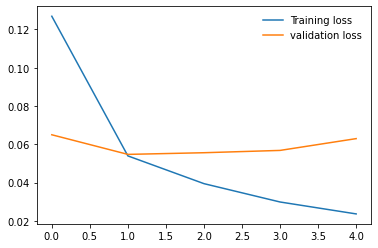

In [ ]:
from matplotlib import pyplot as plt

plt.plot(train_loss_data, label="Training loss")
plt.plot(valid_loss_data, label="validation loss")
plt.legend(frameon=False)

In [ ]:
import pandas as pd

score_df = pd.DataFrame.from_dict(score_data_list)
score_df.head()

,Accuracy,precision,recall,f1
0,0.993474,0.760569,0.815402,0.787032
1,0.993761,0.755532,0.854686,0.802056
2,0.993928,0.761476,0.858328,0.807007
3,0.993565,0.733818,0.886483,0.802959
4,0.993854,0.745686,0.886917,0.810193


# Prepare For Testing

Load best model

In [ ]:
model.load_state_dict(torch.load("nbme_pubmed_bert.pth", map_location = DEVICE))

<All keys matched successfully>

In [ ]:
def create_test_df():
    feats = pd.read_csv(f"{BASE_URL}/features.csv")
    notes = pd.read_csv(f"{BASE_URL}/patient_notes.csv")
    test = pd.read_csv(f"{BASE_URL}/test.csv")

    merged = test.merge(notes, how="left")
    merged = merged.merge(feats, how="left")

    def process_feature_text(text):
        return text.replace("-OR-", ";-").replace("-", " ")
    
    merged["feature_text"] = [process_feature_text(x) 
                              for x in merged["feature_text"]]
    
    return merged


class SubmissionDataset(Dataset):
    def __init__(self, data, tokenizer, config):
        self.data = data
        self.tokenizer = tokenizer
        self.config = config
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        example = self.data.loc[idx]
        tokenized = self.tokenizer(
            example["feature_text"],
            example["pn_history"],
            truncation = self.config['truncation'],
            max_length = self.config['max_length'],
            padding = self.config['padding'],
            return_offsets_mapping = self.config['return_offsets_mapping']
        )
        tokenized["sequence_ids"] = tokenized.sequence_ids()

        input_ids = np.array(tokenized["input_ids"])
        attention_mask = np.array(tokenized["attention_mask"])
        token_type_ids = np.array(tokenized["token_type_ids"])
        offset_mapping = np.array(tokenized["offset_mapping"])
        sequence_ids = np.array(tokenized["sequence_ids"])\
                        .astype("float16")

        return input_ids, attention_mask, token_type_ids, offset_mapping, sequence_ids


test_df = create_test_df()

submission_data = SubmissionDataset(test_df, tokenizer, hyperparameters)
submission_dataloader = DataLoader(submission_data,
                                   batch_size=hyperparameters['batch_size'],
                                   shuffle=False)



In [ ]:
model.eval()
preds = []
offsets = []
seq_ids = []

for batch in tqdm(submission_dataloader):
    input_ids = batch[0].to(DEVICE)
    attention_mask = batch[1].to(DEVICE)
    token_type_ids = batch[2].to(DEVICE)
    offset_mapping = batch[3]
    sequence_ids = batch[4]

    logits = model(input_ids, attention_mask, token_type_ids)
    
    preds.append(logits.detach().cpu().numpy())
    offsets.append(offset_mapping.numpy())
    seq_ids.append(sequence_ids.numpy())

preds = np.concatenate(preds, axis=0)
offsets = np.concatenate(offsets, axis=0)
seq_ids = np.concatenate(seq_ids, axis=0)

  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
location_preds = get_location_predictions(preds, offsets, seq_ids, test=True)

In [ ]:
len(location_preds), len(test_df)

(5, 5)

In [ ]:
test_df["location"] = location_preds

In [ ]:
test_df[["id", "location"]].to_csv("submission6.csv", index = False)
pd.read_csv("submission6.csv").head()

,id,location
0,00016_000,696 724
1,00016_001,668 693; 0 0; 0 0; 0 0; 0 0; 0 0
2,00016_002,203 217; 0 0; 0 0; 0 0
3,00016_003,0 0; 70 91; 0 0; 0 0; 0 0; 0 0
4,00016_004,222 258; 0 0; 0 0


In [ ]:
pd.read_csv(f"{BASE_URL}/test.csv")

,id,case_num,pn_num,feature_num
0,00016_000,0,16,0
1,00016_001,0,16,1
2,00016_002,0,16,2
3,00016_003,0,16,3
4,00016_004,0,16,4
